In [1]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [29]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import ta
import plotly.express as px
import matplotlib.pyplot as plt
import tqdm
from tqdm.auto import tqdm
from tqdm import tqdm
from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
from keras.layers import Bidirectional
from sklearn import metrics
from collections import deque
from scipy.interpolate import interp1d
from keras.utils import to_categorical
from tensorflow.keras import initializers
from keras.callbacks import ModelCheckpoint
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_sample_weight
import random
from tensorflow.keras import regularizers


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# Распаковка данных

In [5]:
ticker = 'MMM'
def read(ticker):
    df1 = pd.read_csv('US1.{0}_060501_100501.csv'.format(ticker))
    df2 = pd.read_csv('US1.{0}_100501_140501.csv'.format(ticker))
    df3 = pd.read_csv('US1.{0}_140501_180501.csv'.format(ticker))
    df4 = pd.read_csv('US1.{0}_180501_200501.csv'.format(ticker))
    
    df1 = df1[df1['<DATE>'] != 20100501]
    df2 = df2[(df2['<DATE>'] != 20140501) & (df2['<DATE>'] != 20140502)]
    df3 = df3[df3['<DATE>'] != 20180501]
    
    df3 = df3.append(df4, ignore_index=True)
    df2 = df3.append(df3, ignore_index=True)
    df = df1.append(df2, ignore_index=True)
    return df


df = read(ticker)
close = df['<CLOSE>']
read(ticker).head(5)

<TICKER>  <PER>    <DATE>  <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>   <VOL>
0  US1.MMM     15  20090601  184500   58.12   58.48  57.930    58.48   47103
1  US1.MMM     15  20090601  190000   58.48   58.59  58.300    58.35   55430
2  US1.MMM     15  20090601  191500   58.34   58.81  58.320    58.80   80251
3  US1.MMM     15  20090601  193000   58.81   59.40  58.805    59.32  121222
4  US1.MMM     15  20090601  194500   59.29   59.39  59.130    59.26  178245

In [6]:
def preprocess(df):
    # создаём технические индикаторы
    df = ta.add_all_ta_features(df, "<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>", "<VOL>", fillna=True)
    
    df['<DATE>'] = df['<DATE>'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df["year"] = df["<DATE>"].dt.year
    df["month"] = df["<DATE>"].dt.month
    df["day"] = df["<DATE>"].dt.day
    df["weekday"] = df["<DATE>"].dt.weekday
    
    time = df['<TIME>'].astype(str)
    new_time = []
    for i in list(time):
        if len(i) == 1:
            new_time.append('00000' + i)
        elif len(i) == 4:
            new_time.append('00' + i)
        else:
            new_time.append(i)
    
    df['time'] = new_time
    df['time'] = df['time'].apply(lambda x: pd.to_datetime(str(x), format='%H%M%S'))
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute

    df['date'] = df['<DATE>']
    df['time'] = df['<TIME>']
    df['open'] = df['<OPEN>']
    df['high'] = df['<HIGH>']
    df['low'] = df['<LOW>']
    df['close'] = df['<CLOSE>']
    df['vol'] = df['<VOL>']

    del df['<TICKER>']
    del df['<PER>']
    del df['<DATE>']
    del df['<TIME>']
    del df['<OPEN>']
    del df['<HIGH>']
    del df['<LOW>']
    del df['<CLOSE>']
    del df['<VOL>']
    del df['time']
    del df['date']
    
    return df

df = preprocess(df)
df.head()

C:\Users\79186\Anaconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\79186\Anaconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


volume_adi  volume_obv  volume_cmf    volume_fi  momentum_mfi  \
0   47103.000000       47103    1.000000     0.000000          50.0   
1   10786.793103       -8327    0.105203 -7205.900000         100.0   
2   87762.242083       71924    0.480142 -1017.492857         100.0   
3  176386.729478      193146    0.580208  8132.926122         100.0   
4  176386.729478       14901    0.365757  5443.265248         100.0   

    volume_em  volume_sma_em    volume_vpt  volume_nvi  volume_vwap  ...  \
0    0.000000       0.000000 -30970.914164      1000.0    58.296667  ...   
1  125.563774     125.563774 -31094.162492      1000.0    58.359737  ...   
2   73.270115      99.416945    495.682409      1000.0    58.484250  ...   
3  263.823811     154.219233   1690.933606      1000.0    58.759685  ...   
4   22.973996     121.407924    891.743025      1000.0    58.944607  ...   

   month  day  weekday  hour  minute   open   high     low  close     vol  
0      6    1        0    18      45  58.12  58.48  57.930  58.48   47103  
1      6    1        0    19       0  58.48  58.59  58.300  58.35   55430  
2      6    1        0    19      15  58.34  58.81  58.320  58.80   80251  
3      6    1        0    19      30  58.81  59.40  58.805  59.32  121222  
4      6    1        0    19      45  59.29  59.39  59.130  59.26  178245  

[5 rows x 83 columns]

In [7]:
fig = px.line(x=df.index, y=df.close)
fig.show()

# Обработка данных 

Создадим таргет на основе анализа локальных минимумов и максимумов. Локальный минимум означает покупать, максимум - продавать

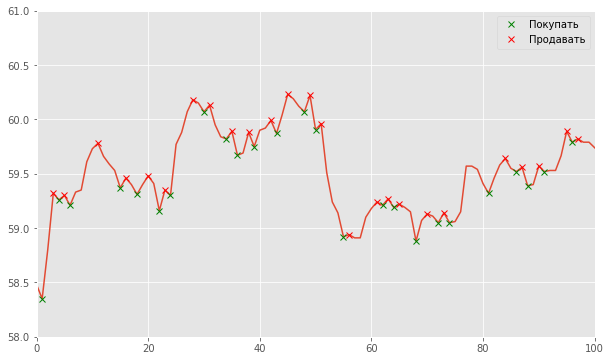

In [10]:
minima = argrelextrema(np.array(df.close), np.less)[0]
maxima = argrelextrema(np.array(df.close), np.greater)[0]

plt.plot(df.index, df.close)
plt.plot(minima, df['close'][minima], "x", c = 'g', label = 'Покупать')
plt.plot(maxima, df['close'][maxima], "x", c='r', label = 'Продавать')
plt.xlim(0,100)
plt.ylim(58,61)
plt.legend()
plt.show()

Проверим, чтобы локальные максимумы и минимумы не пересекались 

In [133]:
print(set(maxima) & set(minima))

set()


In [13]:
#0 - Продавать, 1 - Покупать, 2 - Держать
df['Продавать'] = 0
df['Покупать'] = 0
df['Держать'] = 0
df['Продавать'][df.index.isin(maxima)] = 1
df['Покупать'][df.index.isin(minima)] = 1
df['Держать'][(df['Продавать'] == 0) & (df['Покупать'] == 0)] = 1
df.head(20)

print(sum(df['Продавать']))
print(sum(df['Покупать']))
print(sum(df['Держать']))

C:\Users\79186\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\79186\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\79186\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20546
20496
43347


Сделаем признаки с лагом на один период назад 

In [14]:
close = df.close
cols = list(df.columns[:-15])
cols.extend(['high',
       'low',  'vol', 'close', 'open'])
for i in tqdm(range(len(cols))):
    df.loc[0, '1 lag {0}'.format(cols[i])] = 0.00001
    df['1 lag {0}'.format(cols[i])][1:] = df[cols[i]][:-1]
    del df[cols[i]]

  0%|          | 0/76 [00:00<?, ?it/s]C:\Users\79186\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

100%|██████████| 76/76 [00:11<00:00,  6.58it/s]


Сохраним на всякий случай

In [15]:
df.head()
df.to_csv('Данные{0}.csv'.format(ticker))

# LSTM модель

In [113]:
ticker = 'MMM'
df = pd.read_csv('Данные{0}.csv'.format(ticker), index_col = 0)
list_classes = ["Держать", "Продавать", "Покупать"]
y_ = np.argmax(df[list_classes].values,1).reshape(-1,1)
df.head()

others_cr  year  month  day  weekday  hour  minute  Продавать  Покупать  \
0   0.000000  2009      6    1        0    18      45          0         0   
1  -0.222298  2009      6    1        0    19       0          0         1   
2   0.547196  2009      6    1        0    19      15          0         0   
3   1.436389  2009      6    1        0    19      30          1         0   
4   1.333789  2009      6    1        0    19      45          0         1   

   Держать  ...  1 lag momentum_ao  1 lag momentum_kama  1 lag momentum_roc  \
0        1  ...            0.00001             0.000010             0.00001   
1        0  ...            0.00000            58.480000             0.00000   
2        1  ...            0.00000            58.421550             0.00000   
3        0  ...            0.00000            58.587413             0.00000   
4        0  ...            0.00000            58.902519             0.00000   

   1 lag others_dr  1 lag others_dlr  1 lag high  1 lag low     1 lag vol  \
0         0.000010          0.000010     0.00001    0.00001       0.00001   
1       -65.751529          0.000000    58.48000   57.93000   47103.00000   
2        -0.222298         -0.222546    58.59000   58.30000   55430.00000   
3         0.771208          0.768250    58.81000   58.32000   80251.00000   
4         0.884354          0.880466    59.40000   58.80500  121222.00000   

   1 lag close  1 lag open  
0      0.00001     0.00001  
1     58.48000    58.12000  
2     58.35000    58.48000  
3     58.80000    58.34000  
4     59.32000    58.81000  

[5 rows x 86 columns]

In [114]:
del df['Держать']
del df['Продавать']
del df['Покупать']

df.head()

others_cr  year  month  day  weekday  hour  minute  1 lag volume_adi  \
0   0.000000  2009      6    1        0    18      45          0.000010   
1  -0.222298  2009      6    1        0    19       0      47103.000000   
2   0.547196  2009      6    1        0    19      15      10786.793103   
3   1.436389  2009      6    1        0    19      30      87762.242083   
4   1.333789  2009      6    1        0    19      45     176386.729478   

   1 lag volume_obv  1 lag volume_cmf  ...  1 lag momentum_ao  \
0           0.00001          0.000010  ...            0.00001   
1       47103.00000          1.000000  ...            0.00000   
2       -8327.00000          0.105203  ...            0.00000   
3       71924.00000          0.480142  ...            0.00000   
4      193146.00000          0.580208  ...            0.00000   

   1 lag momentum_kama  1 lag momentum_roc  1 lag others_dr  1 lag others_dlr  \
0             0.000010             0.00001         0.000010          0.000010   
1            58.480000             0.00000       -65.751529          0.000000   
2            58.421550             0.00000        -0.222298         -0.222546   
3            58.587413             0.00000         0.771208          0.768250   
4            58.902519             0.00000         0.884354          0.880466   

   1 lag high  1 lag low     1 lag vol  1 lag close  1 lag open  
0     0.00001    0.00001       0.00001      0.00001     0.00001  
1    58.48000   57.93000   47103.00000     58.48000    58.12000  
2    58.59000   58.30000   55430.00000     58.35000    58.48000  
3    58.81000   58.32000   80251.00000     58.80000    58.34000  
4    59.40000   58.80500  121222.00000     59.32000    58.81000  

[5 rows x 83 columns]

In [115]:
print('Total number of features', df.shape[1])
X_ = df.values
mm_scaler = MinMaxScaler(feature_range=(0, 1))
X = mm_scaler.fit_transform(X_)
print(X.shape)
print(y_.shape)

Total number of features 83
(84389, 83)
(84389, 1)


In [116]:
del [df]
gc.collect()

36291

In [117]:
Time_steps = 16
def lstm_data_transform(x_data, y_data, num_steps=Time_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

X, y = lstm_data_transform(X, y_)

In [118]:
test_size = 0.1
X_train = X[:round(X.shape[0] * (1 - test_size)), :]
X_val = X[X_train.shape[0]: round(X_train.shape[0] + (X.shape[0] - X_train.shape[0])/2) , :]
X_test =  X[round(X_train.shape[0] + (X.shape[0] - X_train.shape[0])/2):, :]
y_train = y[:round(y.shape[0] * (1 - test_size))]
y_val = y[y_train.shape[0]: round(y_train.shape[0] + (y.shape[0] - y_train.shape[0])/2)]
y_test =  y[round(y_train.shape[0] + (y.shape[0] - y_train.shape[0])/2):]

print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84373, 16, 83)
(84373, 1)
(75936, 16, 83)
(4218, 16, 83)
(4219, 16, 83)
(75936, 1)
(4218, 1)
(4219, 1)


In [119]:
weights = compute_sample_weight(class_weight="balanced", y=y_train)
weights

array([1.36954875, 0.64877611, 1.37274256, ..., 0.64877611, 0.64877611,
       0.64877611])

In [120]:
from keras import backend as K
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis = 1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_f1 = metrics.classification_report(val_targ, val_predict, output_dict = True)['macro avg']['f1-score']
        self.val_f1s.append(_val_f1)
        print(' — val_f1: %f' %(_val_f1))
        return

In [124]:
METRICS = ['accuracy']
batch_size = 1024

model = Sequential()
model.add(LSTM(32, activation = 'tanh', input_shape=(Time_steps, X_train.shape[2])))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-1, l2=1e-1)))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=METRICS)

filepath="GS-weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,verbose=1)
callbacks_list = [checkpoint, Metrics()]

history = model.fit(X_train, y_train, epochs=5, 
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data=(X_val, y_val), sample_weight=weights, callbacks = callbacks_list)

Train on 75936 samples, validate on 4218 samples
Epoch 1/5
75936/75936 [==============================] - ETA: 1:28 - loss: 12.8159 - accuracy: 0.247 - ETA: 1:00 - loss: 12.7569 - accuracy: 0.261 - ETA: 50s - loss: 12.7160 - accuracy: 0.296 - ETA: 45s - loss: 12.6774 - accuracy: 0.32 - ETA: 41s - loss: 12.6433 - accuracy: 0.34 - ETA: 39s - loss: 12.6088 - accuracy: 0.35 - ETA: 38s - loss: 12.5770 - accuracy: 0.35 - ETA: 38s - loss: 12.5441 - accuracy: 0.35 - ETA: 36s - loss: 12.5104 - accuracy: 0.35 - ETA: 35s - loss: 12.4753 - accuracy: 0.35 - ETA: 34s - loss: 12.4408 - accuracy: 0.35 - ETA: 33s - loss: 12.4073 - accuracy: 0.35 - ETA: 32s - loss: 12.3731 - accuracy: 0.35 - ETA: 32s - loss: 12.3395 - accuracy: 0.35 - ETA: 31s - loss: 12.3063 - accuracy: 0.35 - ETA: 30s - loss: 12.2727 - accuracy: 0.35 - ETA: 30s - loss: 12.2385 - accuracy: 0.35 - ETA: 30s - loss: 12.2044 - accuracy: 0.35 - ETA: 29s - loss: 12.1700 - accuracy: 0.35 - ETA: 28s - loss: 12.1360 - accuracy: 0.34 - ETA: 28s 

C:\Users\79186\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



 — val_f1: 0.000158
Epoch 2/5
75936/75936 [==============================] - ETA: 29s - loss: 8.1885 - accuracy: 0.280 - ETA: 33s - loss: 8.1447 - accuracy: 0.283 - ETA: 32s - loss: 8.1178 - accuracy: 0.291 - ETA: 31s - loss: 8.0975 - accuracy: 0.295 - ETA: 30s - loss: 8.0766 - accuracy: 0.299 - ETA: 29s - loss: 8.0517 - accuracy: 0.304 - ETA: 28s - loss: 8.0253 - accuracy: 0.311 - ETA: 28s - loss: 8.0023 - accuracy: 0.314 - ETA: 28s - loss: 7.9774 - accuracy: 0.318 - ETA: 28s - loss: 7.9520 - accuracy: 0.321 - ETA: 28s - loss: 7.9266 - accuracy: 0.324 - ETA: 27s - loss: 7.9029 - accuracy: 0.323 - ETA: 27s - loss: 7.8767 - accuracy: 0.322 - ETA: 26s - loss: 7.8512 - accuracy: 0.323 - ETA: 26s - loss: 7.8259 - accuracy: 0.322 - ETA: 25s - loss: 7.8005 - accuracy: 0.322 - ETA: 25s - loss: 7.7761 - accuracy: 0.322 - ETA: 25s - loss: 7.7522 - accuracy: 0.323 - ETA: 24s - loss: 7.7272 - accuracy: 0.322 - ETA: 23s - loss: 7.7033 - accuracy: 0.321 - ETA: 23s - loss: 7.6786 - accuracy: 0.318 -

C:\Users\79186\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



 — val_f1: 0.000000
Epoch 4/5
75936/75936 [==============================] - ETA: 27s - loss: 2.8161 - accuracy: 0.267 - ETA: 27s - loss: 2.7892 - accuracy: 0.262 - ETA: 27s - loss: 2.7755 - accuracy: 0.258 - ETA: 27s - loss: 2.7675 - accuracy: 0.258 - ETA: 27s - loss: 2.7577 - accuracy: 0.263 - ETA: 28s - loss: 2.7481 - accuracy: 0.265 - ETA: 28s - loss: 2.7362 - accuracy: 0.267 - ETA: 28s - loss: 2.7275 - accuracy: 0.271 - ETA: 27s - loss: 2.7177 - accuracy: 0.281 - ETA: 27s - loss: 2.7108 - accuracy: 0.288 - ETA: 26s - loss: 2.7026 - accuracy: 0.294 - ETA: 26s - loss: 2.6914 - accuracy: 0.301 - ETA: 26s - loss: 2.6816 - accuracy: 0.305 - ETA: 26s - loss: 2.6717 - accuracy: 0.308 - ETA: 25s - loss: 2.6612 - accuracy: 0.311 - ETA: 25s - loss: 2.6507 - accuracy: 0.315 - ETA: 24s - loss: 2.6410 - accuracy: 0.321 - ETA: 24s - loss: 2.6306 - accuracy: 0.326 - ETA: 24s - loss: 2.6210 - accuracy: 0.329 - ETA: 23s - loss: 2.6107 - accuracy: 0.333 - ETA: 23s - loss: 2.6007 - accuracy: 0.337 -

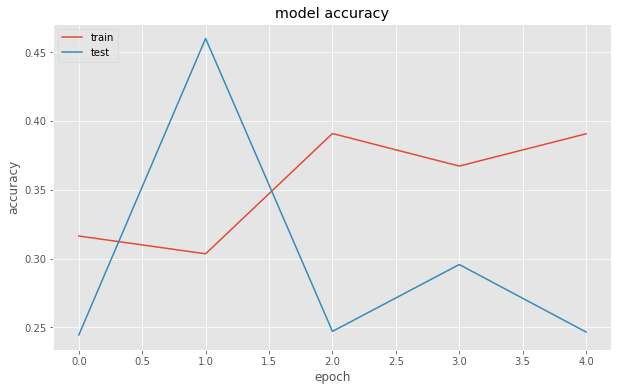

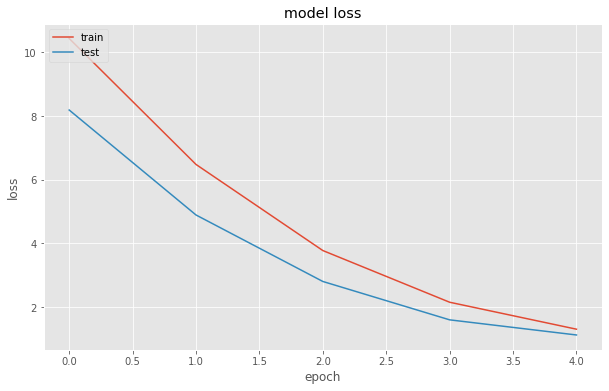

In [125]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
model.load_weights("GS-weights-improvement-02-0.46-4.89.hdf5")

In [127]:
test_predict = model.predict(X_test)

(array([2187.,    0.,    0.,    0.,    0., 1019.,    0.,    0.,    0.,
        1013.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

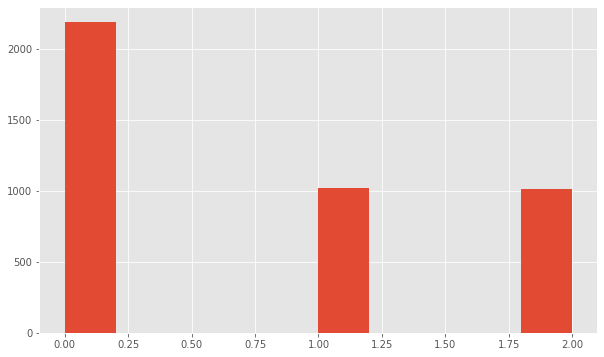

In [128]:
plt.hist(y_test)

(array([3041.,    0.,    0.,    0.,    0.,  461.,    0.,    0.,    0.,
         717.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

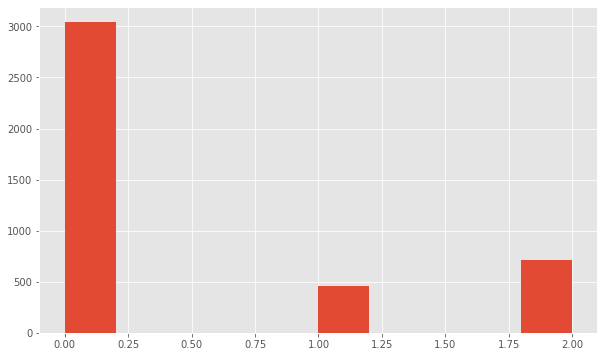

In [129]:
label_pred =  np.argmax(test_predict, axis = 1)
label_pred
plt.hist(label_pred)

In [130]:
y_true  = y_test
y_pred = label_pred
    
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

#print(multiclass_roc_auc_score(y_test, y_pred, average="micro"))

[[1568  245  374]
 [ 740  113  166]
 [ 733  103  177]]
              precision    recall  f1-score   support

           0      0.516     0.717     0.600      2187
           1      0.245     0.111     0.153      1019
           2      0.247     0.175     0.205      1013

    accuracy                          0.440      4219
   macro avg      0.336     0.334     0.319      4219
weighted avg      0.386     0.440     0.397      4219



# Сравним с логит моделью

In [131]:
X_train_ = X_[:round(X_.shape[0] * (1 - test_size)), :]
X_val_ = X_[X_train_.shape[0]: round(X_train_.shape[0] + (X_.shape[0] - X_train_.shape[0])/2) , :]
X_test_ =  X_[round(X_train_.shape[0] + (X_.shape[0] - X_train_.shape[0])/2):, :]
y_train_ = y_[:round(y_.shape[0] * (1 - test_size))]
y_val_ = y_[y_train_.shape[0]: round(y_train_.shape[0] + (y_.shape[0] - y_train_.shape[0])/2)]
y_test_ =  y_[round(y_train_.shape[0] + (y_.shape[0] - y_train_.shape[0])/2):]

print(X_.shape)
print(y_.shape)
print(X_train_.shape)
print(X_val_.shape)
print(X_test_.shape)
print(y_train_.shape)
print(y_val_.shape)
print(y_test_.shape)

(84389, 83)
(84389, 1)
(75950, 83)
(4220, 83)
(4219, 83)
(75950, 1)
(4220, 1)
(4219, 1)


In [132]:
clf = LogisticRegression(random_state=0, multi_class = 'multinomial', solver = 'newton-cg', class_weight = 'balanced')
clf.fit(X_train_, y_train_)
y_pred_clf = clf.predict(X_test_)

C:\Users\79186\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\79186\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning:

The line search algorithm did not converge

C:\Users\79186\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

C:\Users\79186\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



Упс, она оказалась лучше ...

In [134]:
y_true  = y_test_
y_pred = y_pred_clf
    
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[671 846 670]
 [286 670  63]
 [285  89 639]]
              precision    recall  f1-score   support

           0      0.540     0.307     0.391      2187
           1      0.417     0.658     0.511      1019
           2      0.466     0.631     0.536      1013

    accuracy                          0.469      4219
   macro avg      0.474     0.532     0.479      4219
weighted avg      0.493     0.469     0.455      4219

